In [1]:
from keras import models
from keras import layers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.datasets import cifar10
import numpy as np
from keras.utils.np_utils import to_categorical
from keras.callbacks import LearningRateScheduler, TensorBoard, ModelCheckpoint
log_filepath  = './inception_resnet_v2'
from skimage.transform import resize
import tensorflow as tf
import skimage
import skimage.io
import skimage.transform

Using TensorFlow backend.


# Load InceptionResNetV2

In [2]:
from keras.applications import InceptionResNetV2

In [3]:
irnv = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(75, 75, 3))

# Fine tuing 1-4 layers

In [4]:
for layer in irnv.layers[:-4]:
    layer.trainable = False

In [5]:
for layer in irnv.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x0000023507DB42B0> False
<keras.layers.convolutional.Conv2D object at 0x0000023507DD1518> False
<keras.layers.normalization.BatchNormalization object at 0x000002350CFF4160> False
<keras.layers.core.Activation object at 0x000002350DB208D0> False
<keras.layers.convolutional.Conv2D object at 0x000002350F466898> False
<keras.layers.normalization.BatchNormalization object at 0x000002350F4F2EF0> False
<keras.layers.core.Activation object at 0x000002350F5206D8> False
<keras.layers.convolutional.Conv2D object at 0x000002350F5B8358> False
<keras.layers.normalization.BatchNormalization object at 0x000002350F5DDA90> False
<keras.layers.core.Activation object at 0x000002350F61FC18> False
<keras.layers.pooling.MaxPooling2D object at 0x000002350F6DCCF8> False
<keras.layers.convolutional.Conv2D object at 0x000002350F6ABA90> False
<keras.layers.normalization.BatchNormalization object at 0x000002350F7AD940> False
<keras.layers.core.Activation object at 0x

In [42]:
 # Create the model
model = models.Sequential()

model.add(irnv)
 
# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 1, 1, 1536)        54336736  
_________________________________________________________________
flatten_2 (Flatten)          (None, 1536)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              1573888   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                10250     
Total params: 55,920,874
Trainable params: 1,584,138
Non-trainable params: 54,336,736
_________________________________________________________________


# Load data

In [22]:
import random
import cv2
from keras.optimizers import SGD

In [7]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

Example training images and their labels: [4, 6, 2, 5, 7]
Corresponding classes for the labels: ['deer', 'frog', 'bird', 'dog', 'horse']


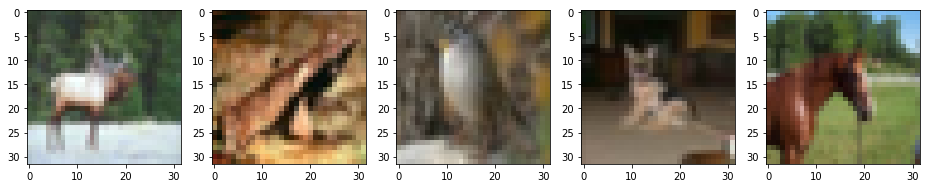

In [36]:
import matplotlib.pyplot as plt

cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print('Example training images and their labels: ' + str([x[0] for x in y_train[0:5]])) 
print('Corresponding classes for the labels: ' + str([cifar_classes[x[0]] for x in y_train[0:5]]))

f, axarr = plt.subplots(1, 5)
f.set_size_inches(16, 6)

for i in range(5):
    img = x_train[i]
    axarr[i].imshow(img)

In [37]:
# limit the amount of the data
# train data
ind_train = random.sample(list(range(x_train.shape[0])), 2000)
x_train = x_train[ind_train]
y_train = y_train[ind_train]

# test data
ind_test = random.sample(list(range(x_test.shape[0])), 2000)
x_test = x_test[ind_test]
y_test = y_test[ind_test]

In [38]:
def resize_data(data):
    data_upscaled = np.zeros((data.shape[0], 75, 75, 3))
    for i, img in enumerate(data):
        large_img = cv2.resize(img, dsize=(75, 75), interpolation=cv2.INTER_CUBIC)
        data_upscaled[i] = large_img

    return data_upscaled

In [39]:
# resize train and  test data
x_train_resized = resize_data(x_train)
x_test_resized = resize_data(x_test)

# make explained variable hot-encoded
y_train_hot_encoded = to_categorical(y_train)
y_test_hot_encoded = to_categorical(y_test)

In [40]:
x_train_resized.shape

(2000, 75, 75, 3)

In [45]:
# freeze pre-trained model area's layer
for layer in model.layers:
    layer.trainable = False

# update the weight that are added
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.fit(x_train_resized, y_train_hot_encoded)

# choose the layers which are updated by training
layer_num = len(model.layers)
for layer in model.layers[:18]:
    layer.trainable = False

for layer in model.layers[18:]:
    layer.trainable = True

Epoch 1/1
2000/2000 [==============================] - 71s 36ms/step - loss: 2.6521


In [43]:
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train_resized, y_train_hot_encoded, batch_size=256, epochs=50, shuffle=True,  validation_split=0.1)

Train on 1800 samples, validate on 200 samples
Epoch 1/50
1800/1800 [==============================] - 80s 44ms/step - loss: 2.6083 - acc: 0.0989 - val_loss: 14.9898 - val_acc: 0.0700
Epoch 2/50
 256/1800 [===>..........................] - ETA: 48s - loss: 2.6169 - acc: 0.0625

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
def show_history(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'test_accuracy'], loc='best')
    plt.show()